##**The M24 encoding scheme:**

For my final project, I wanted to look into Quantum Cryptography, and try making my own encoding scheme. Traditionally, the encodings are named as (First letter of last name) + Year, so I named mine M24. The scheme goes as follows:

####**Phase 1:**
Phase 1 uses the principles behind the E19 encoding key distribution. The what is nice about E19, is that eavesdropping detection is automatic. Eavesdropping is when a 3rd, untrusted party trys to intercept communication between two parties. In these scenarios, we will call the communicators Alice and Bob, and the 3rd party, and eavsdropper Eve. Our communication starts with a third party sending entangled qubits to Alice and Bob. For our scheme, we will have the third party send 7 qubits. Qubits 0-3 will determine how many quantum walks will be performed (part of the later encoding) and qubits 4-6 will determine what is the inital "shift" gate, choosing between Pauli X, Pauli Y, and Pauli Z gates (also used later). The 3rd party will send these entangled bits to Alice and Bob, and they will measure them in random baseses. If the correlation between the measurements that Alice and Bob take does not align with a certain distribution, Alice and Bob know that Eve was not truly sending entangled qubits, and they can cease communication. Because of this Eve, the distributor, does not need to be trusted. If the qubits correlate then Alice and Bob can move on to phase 2, but for my exmaple coded below, I made it so that Alice and Bob will always receive a correct key, which will be a completely random key, that I have adjusted so that the number of walks is always even, and so that there is no issue with the gates, for example the last three bits being 111, when they should only ever be 100, 010, and 001 (X, Y and Z). I chose the number of walks to always be even so that it could be decoded. Below is a visual to demonstrate this.

####**Phase 2:**
Phase 2 involved encoding a message using my encoding scheme. The idea behind my scheme are quantum walks. Quanutum walks are the similar to classical random walks, but incorporate the super position of a qubit to "cover all possibilities at once". To do this on a single qubit, the Hadamard gate can be used, which sends the qubit into a super position. The gate is also unitary, meaning that it can be undone, so the receiver of the message can undo the encoding if they know what shifts were used, and how many times the walk occured. The circuit for this encoding is:

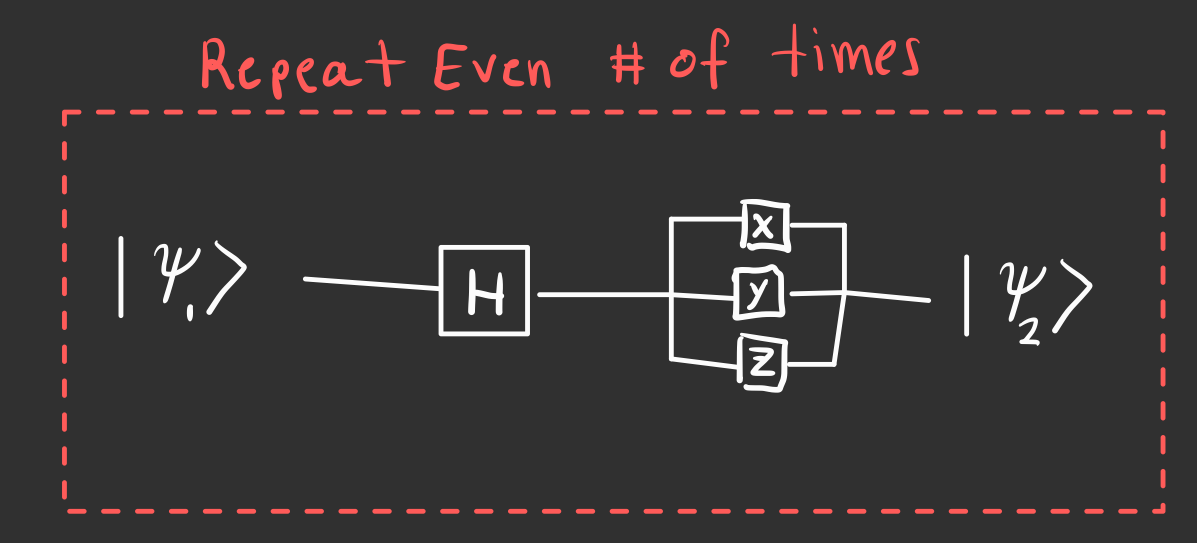

In the diagram, H is the Hadamard gate, and X, Y and Z are the corresponding Pauli gates, that are used depending on the key distributed in Phase 1. The reason that the encoding is done an even amount of times, is because if it weren't the encoding and decoding wouldn't be symmetrical, so it would be impossible to reliably decode the message as demonstrated by this diagram:

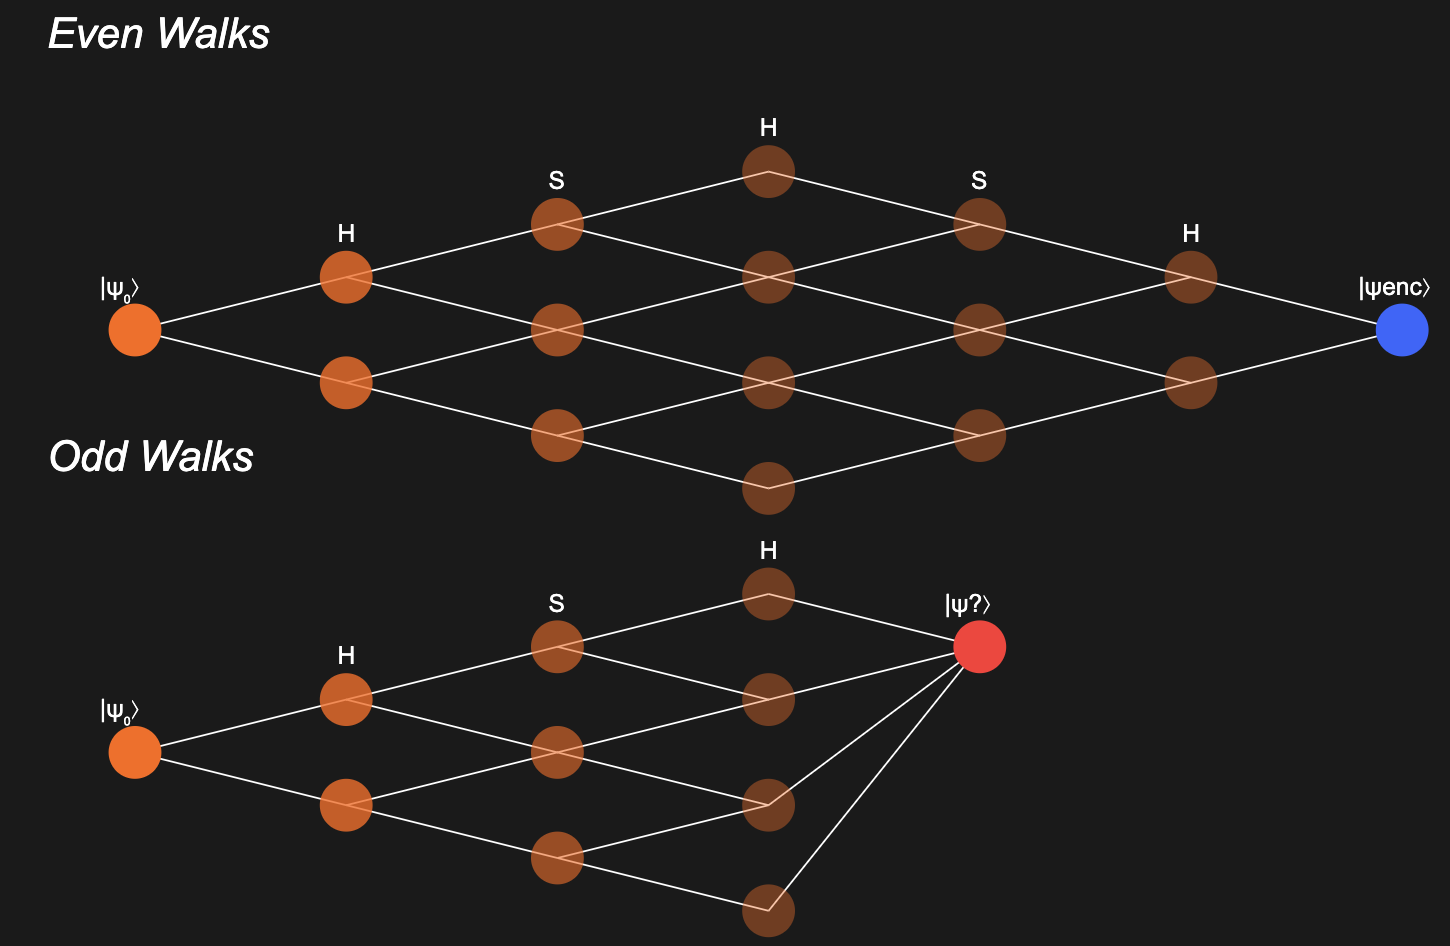

The reason I wanted to add this quantum walk step is so that Alice and Bob could communicate on an open channel, knowing that they are safe from eavesdroppers, because if the qubits were measured prematurely, the message would be destroyed because the superposition would collapse. Further, only Alice and Bob could know the key that allows them to decode the message, because of the inherent randomness from the E91 key distribution.

####**Phase 3:**
Finally, in Phase 3, the inverse of the decoding is done using the Hadamard dagger and the Pauli dagger gates.

In conclusion, I am pretty satisfied with the encoding, but in the future if I had more time, I would want to improve it slightly. One flaw with the the quantum walk method is that there is a chance that when the message is encoded, the walk has actually come back to the initial state (walked in a circle). I would want to add a safeguard for this in the future.

In [ ]:
!pip install pennylane

In [ ]:
import pennylane as qml
import numpy as np

In [ ]:
# Define the device to run circuits
dev = qml.device("default.qubit", wires=1, shots=1)

@qml.qnode(dev)
def apply_hadamard():
    qml.Hadamard(wires=0)
    return qml.sample()

@qml.qnode(dev)
def quantum_walk_encode(bit, walkEncode, numberOfWalks, shift):
    # Initialize state
    if bit == '1':
        qml.PauliX(wires=0)

    # Forward walk
    for _ in range(numberOfWalks):
        qml.Hadamard(wires=0)
        if shift == '100':
            qml.PauliX(wires=0)
        elif shift == '010':
            qml.PauliY(wires=0)
        elif shift == '001':
            qml.PauliZ(wires=0)

    return qml.sample()

@qml.qnode(dev)
def quantum_walk_decode(bit, walkEncode, numberOfWalks, shift):
    # Initialize with received state
    if bit == '1':
        qml.PauliX(wires=0)

    # Reverse walk
    for _ in range(numberOfWalks):
        if shift == '100':
            qml.PauliX(wires=0)
        elif shift == '010':
            qml.PauliY(wires=0)
        elif shift == '001':
            qml.PauliZ(wires=0)
        qml.Hadamard(wires=0)

    return qml.sample()

def string_to_binary(input_string):
    return ' '.join(format(ord(char), '08b') for char in input_string)

def binary_list_to_string(binary_list):
    binary = ''.join(map(str, binary_list))
    return ''.join(chr(int(binary[i:i+8], 2)) for i in range(0, len(binary), 8))


In [ ]:
# Key generation (Phase 1)
walkEncode = []
for _ in range(7):
    measurement = apply_hadamard()
    print("Measurement outcome:", measurement)
    walkEncode.append(int(measurement))

# Ensure single shift type
shiftFound = False
for i in range(len(walkEncode)):
    if shiftFound:
        walkEncode[i] = 0
    if walkEncode[i] == 1 and i >= 4:
        shiftFound = True

if ''.join(map(str, walkEncode[4:7])) == '000':
    walkEncode[4] = 1  # Default to X gate if no shift

print("Quantum walk encoding:", walkEncode)

# Message encoding (Phase 2)
# Some sample messages
aliceMessage = "hi bob"
# aliceMessage = "Modern physics has expanded far beyond the classical mechanics of Newton. Special relativity revealed that time and space are intertwined, with time dilation and length contraction occurring at velocities approaching the speed of light."
aliceBin = string_to_binary(aliceMessage).replace(' ', '')
print("Alice's message to Bob:", aliceMessage, "->", aliceBin)

# Calculate walks but ensure it's even
numberOfWalks = int(''.join(map(str, walkEncode[0:4])), 2)
if numberOfWalks % 2 == 1:  # If odd, make it even
    numberOfWalks += 1
    print("Adjusted walks to even number")

shift = ''.join(map(str, walkEncode[4:7]))
shiftGate = ""
if shift == '100':
    shiftGate = "X"
elif shift == '010':
    shiftGate = "Y"
elif shift == '001':
    shiftGate = "Z"
print("Number of walks:", numberOfWalks)
print("Shift gate:", shift, "(", shiftGate, ")")

# Encode
encodedString = []
for bit in aliceBin:
    encoded_bit = quantum_walk_encode(bit, walkEncode, numberOfWalks, shift)
    encodedString.append(int(encoded_bit))
    if shift == '100':
        shift='010'
    elif shift == '010':
        shift='001'
    elif shift == '001':
        shift='100'
print("Encoded string:", encodedString)
print("Encoded message:", binary_list_to_string(encodedString))

# Decode
decodedString = []
for bit in encodedString:
    decoded_bit = quantum_walk_decode(str(bit), walkEncode, numberOfWalks, shift)
    decodedString.append(int(decoded_bit))
    if shift == '100':
        shift='010'
    elif shift == '010':
        shift='001'
    elif shift == '001':
        shift='100'

print("Decoded string:", decodedString)
print("Decoded message:", binary_list_to_string(decodedString))

# Verification
print("\nVerification:")
print("Input binary :", aliceBin)
decoded_binary = ''.join(map(str, decodedString))
print("Output binary:", decoded_binary)
print("Bits match   :", aliceBin == decoded_binary)

Measurement outcome: 1
Measurement outcome: 1
Measurement outcome: 1
Measurement outcome: 0
Measurement outcome: 0
Measurement outcome: 1
Measurement outcome: 0
Quantum walk encoding: [1, 1, 1, 0, 0, 1, 0]
Alice's message to Bob: hi bob -> 011010000110100100100000011000100110111101100010
Number of walks: 14
Shift gate: 010 ( Y )
Encoded string: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
Encoded message: ßûÙ¹
Decoded string: [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0]
Decoded message: hi bob

Verification:
Input binary : 011010000110100100100000011000100110111101100010
Output binary: 011010000110100100100000011000100110111101100010
Bits match   : True
